In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import calendar
import time
import tensorflow as tf
import gensim

from sklearn import metrics
from sklearn.metrics import f1_score, hamming_loss, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

2023-12-04 10:51:43.249846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df = pd.read_excel('/Users/suhas.kamuni/Downloads/Merged_Training_Set.xlsx')
train_df.drop(['Platform.1'], axis = 1)

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Source,Month,Predicted Team
0,158994127,Keine vernünftige Struktur wie bei Web Version...,Not a reasonable structure as with web version...,1,21.10.2022,NaN,Android,EasyFeedback,September,People/Homepage
1,158999921,Ich finde vorher war übersicht besser.,I think before was overview better.,2,21.10.2022,NaN,Android,EasyFeedback,September,Design System
2,159009543,Teilweise mühsame Navigation,Partly tedious navigation,3,22.10.2022,NaN,Android,EasyFeedback,September,General
3,159010950,Unpraktische Bedienung,Impractical operation,2,22.10.2022,NaN,Android,EasyFeedback,September,General
4,159033855,"Mich stört, dass laufend irgendwelche Besucher...",It bothers me that some visitors can constantl...,2,22.10.2022,NaN,Android,EasyFeedback,September,Profile
...,...,...,...,...,...,...,...,...,...,...
1788,169331349,Viel zu teuer - möchte kündigen - keine Option...,Way too expensive - want to cancel - no option...,3,25.03.2023 | 12:43,NaN,iOS,EasyFeedback,March,CPAY
1789,170340338,"Zu teuer, zu viel Werbung.","Too expensive, too much advertising.",2,08.04.2023 | 08:33,NaN,Android,EasyFeedback,April,CPAY
1790,171527475,Kosten,Cost,3,25.04.2023 | 19:23,NaN,Android,EasyFeedback,April,CPAY
1791,a03f98f6-bb97-4e90-8885-de666236e05e,Einfach unverschämt diese App. Geld für ein Ja...,Simply outrageous this app. Pull out money for...,1,2023-05-30 00:00:00,23.13.1m,Android,Data.AI,May,CPAY


In [1]:
train_df

NameError: name 'train_df' is not defined

In [3]:
# Get Labeled tweets vocabulary
# put all tokens of each tweet in one set
total_vocabulary = train_df['Converted English']
len(total_vocabulary)
print ('There are unique tokens in the dataset.'.format (len (total_vocabulary) ))

There are unique tokens in the dataset.


In [4]:
# Get 100d GloVe embeddings for each word present in the vocabulary
glove_dir = '/Users/suhas.kamuni/Downloads/glove/'

glove = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove))

Found 400000 word vectors.


In [5]:
import re
import string 
from wordcloud import WordCloud, STOPWORDS

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def clean_text(input_txt):
    input_txt = input_txt.str.replace("[^a-zA-Z#]", " ") # removes special chars
    input_txt = input_txt.str.strip() # removes white spaces
    input_txt = input_txt.str.lower() # converts to lower case
    input_txt = input_txt.fillna('') 

    p = string.punctuation
    table = str.maketrans('','',p)
    #df['data'] = df.fillna({'data':''})
    input_txt = input_txt.apply(lambda x:x.translate(table))
    input_txt = input_txt.apply(lambda x:x.split(' ')) #tokenising each word

    stopwords = set(STOPWORDS) 
    input_txt = input_txt.apply(lambda x: [word for word in x if word not in stopwords]) # removing stopwords

    ps = nltk.PorterStemmer() # stem the thing
    input_txt = input_txt.apply(lambda x: [ps.stem(word) for word in x])
    input_txt = input_txt.apply(lambda x: ' '.join([word for word in x if len(word) > 1])) # removing single letter

    input_txt = np.vectorize(remove_pattern)(input_txt, "@[\w]*")

    return input_txt

def train_classifier(X_try, y_try, clf):
    if clf == "ada_clf": clf = ada_clf
    elif clf == "LR_502": clf = LR_502
    elif clf == "LR_1": clf = LR_1
    elif clf == "rnf": clf = rnf
    elif clf == "svm": clf = SVM
    elif clf == "dtree": clf = DTree 
    elif clf == "knn5":clf = knn5
    elif clf == "kmeans" :clf = kmeans
    elif clf == "gnb" :clf = gnb
    elif clf == "xgbc" :clf = xgbc
    
    pipe = Pipeline([
            ("Vectorizer_tfidf", vectorizer_tfidf),
            #("Scaler", Scaler),
            ("",clf)
        ])
    pipe.fit(X_try, y_try)

    # Return the trained classifier
    return pipe


def pipe_try(xx_test, yy_test, model):
    print('========================== {} ==========================\n'.format(model))
    print("\t \t \t\t \t------------------")
    print("\t \t \t \t \tF1 Score: ", round(f1_score(yy_test, model.predict(xx_test), average='macro')*100,2),"%")
    print("\t \t \t\t \tAccuracy: ", round(metrics.accuracy_score(yy_test, model.predict(xx_test))*100,2),"%")
    print("    \t \t \t \t       Hamming Loss: ", round(hamming_loss(yy_test, model.predict(xx_test)), 2))
    print("    \t \t \t \t   Weighted F1 Score: ",round(f1_score(yy_test, model.predict(xx_test), average='weighted')*100,2),"%")
    print("    \t \t \t \t   ---------------------------\n")
    print('================================= Pipeline Specifications ==================================')
    print(model)
    #print("\n")
    #print(metrics.classification_report(yy_test, pr.predict(xx_test)))


def best_scores(m, n):
    acc = []
    for i in range(n):
        model = m.fit(X_train, y_train)
        acc.append(round(f1_score(y_test, model.predict(X_test), average='macro')*100,2))

    unique_elements = [x for i, x in enumerate(acc) if x not in acc[:i]]
    unique_elements.sort(reverse=True)
    acc = unique_elements[:5]
    for i in acc: print(i.astype(str) + '%') 
    

def best_model(model, n):
    start_time = time.time()
    acc = []
    for i in range(n):
        model = model.fit(X_train, y_train)
        acc.append(round(f1_score(y_test, model.predict(X_test), average='macro')*100,2))
        
    while n>0:
        model = model.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        if elapsed_time > 60:
            #print("$")
            acc_u = [x for i, x in enumerate(acc) if x not in acc[:i]]
            acc_u.sort(reverse=True)
            if round(f1_score(y_test, model.predict(X_test), average='macro')*100,2) == acc_u[1:2]:
                #print("^")
                break
        
        if round(f1_score(y_test, model.predict(X_test), average='macro')*100,2) == max(acc):
            #print("%")
            break

    #print(round(f1_score(y_test, model.predict(X_test), average='macro')*100,2))
    #acc = [x for i, x in enumerate(acc) if x not in acc[:i]]
    #acc.sort(reverse = True)
    #print(acc[:5])
    #print(f"Elapsed time: {elapsed_time:.2f} seconds")
    #print(elapsed_time)
    return model        

In [6]:
class W2vVectorizer(object): 
    """ class to generate mean word embeddings from word vectors. 
    This class is quoted from Flatiron School Curriculum Learn.co Mod 4 appendix """
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next (iter (glove)) ])

        # Note: Even though it doesn't do anything,
        # it's required that this object implement a fit method or else
        # it can t be used in a scikit-learn pipeline

    def fit (self, X, Y):
        return self
    
    def transform(self, X): 
        # × should be a series of lists of tokens
        return np.array([np.mean ( [self.w2v[w] for w in words if w in self.w2v] or [np.zeros (self.dimensions) ], axis=0) for words in X])

In [7]:
# Instantiate a mean word embedding vectorizer using glove embeddings
vectorizer = W2vVectorizer(glove)
train_df['text_token'] = train_df['Converted English'].apply(lambda x: gensim.utils.simple_preprocess(x))

# X_glove = vectorizer.transform(train_df['text_token'])
X_glove = vectorizer.transform(train_df['Converted English'])
y = train_df['Predicted Team']

rnf = RandomForestClassifier(n_estimators=100) 

X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, y_train.shape

((1434, 100), (1434,))

In [8]:
rf_glove = RandomForestClassifier(random_state=1)
rf_glove.fit(X_train, y_train)
y_pred = rf_glove.predict(X_test)

In [9]:
print(metrics.classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

                 Ads       0.20      0.05      0.08        19
                CPAY       0.25      0.14      0.18         7
Content Architecture       0.00      0.00      0.00        16
       Design System       0.00      0.00      0.00        24
             General       0.41      0.90      0.56       134
            Insights       0.50      0.05      0.09        21
                Jobs       0.22      0.11      0.14        19
 LinkedIn comparison       0.00      0.00      0.00        12
           Messenger       0.25      0.15      0.19        13
        Notification       0.00      0.00      0.00         9
     People/Homepage       0.35      0.24      0.28        34
             Premium       0.14      0.06      0.09        16
             Profile       0.00      0.00      0.00        12
 Reference to Groups       1.00      0.08      0.14        13
              Upsell       0.00      0.00      0.00        10

      

/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Text(0.5, 1.0, 'Confusion Matrix\n')

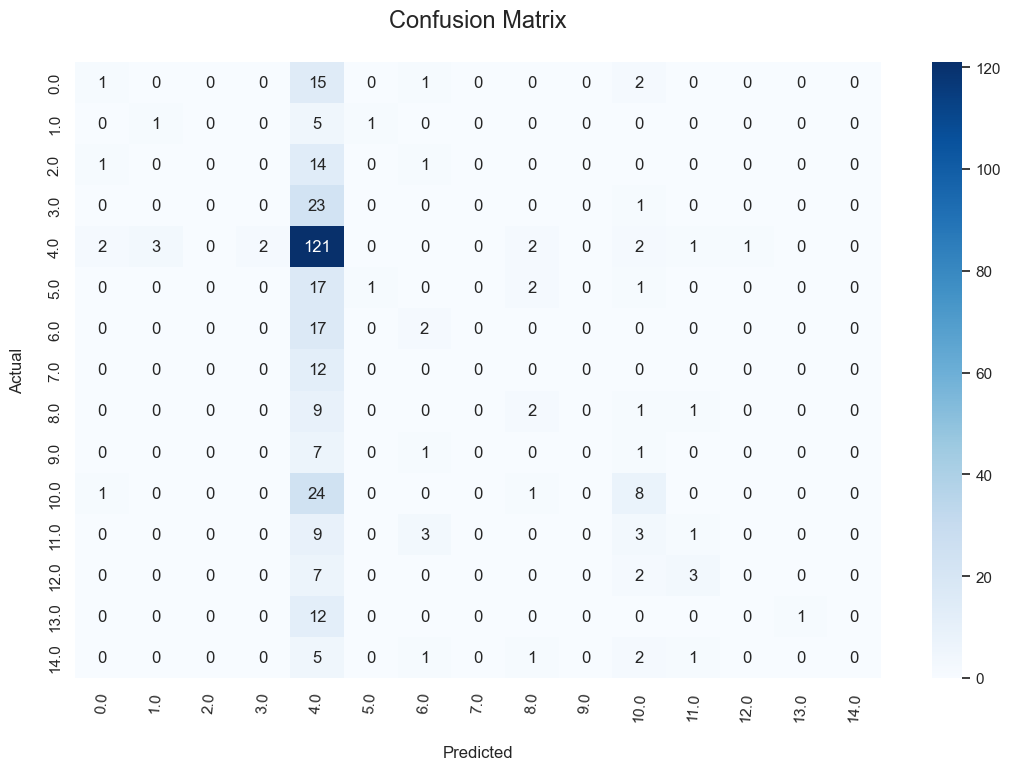

In [10]:
sns.set(font_scale=1.0)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(13,8))

sns.heatmap(cm, 
            annot=True, 
            cmap="Blues", 
            fmt='d',
            xticklabels = rf_glove[-1].classes_,
            yticklabels = rf_glove[-1].classes_,
            )

plt.ylabel('Actual\n')
plt.xlabel('\nPredicted')
plt.xticks(rotation = 85)
plt.title("Confusion Matrix\n", size = 17)

In [15]:
pipe_try(X_test, y_test, rf_glove)

========================== RandomForestClassifier(random_state=1) ==========================

	 	 		 	------------------
	 	 	 	 	F1 Score:  11.72 %
	 	 		 	Accuracy:  38.44 %
    	 	 	 	       Hamming Loss:  0.62
    	 	 	 	   Weighted F1 Score:  27.27 %
    	 	 	 	   ---------------------------

================================= Pipeline Specifications ==================================
RandomForestClassifier(random_state=1)


In [12]:
LR_502 = LogisticRegression(C=502, solver='liblinear')
lr_model = LR_502.fit(X_train, y_train.values.ravel())
pipe_try(X_test, y_test, lr_model)

========================== LogisticRegression(C=502, solver='liblinear') ==========================

	 	 		 	------------------
	 	 	 	 	F1 Score:  14.49 %
	 	 		 	Accuracy:  38.44 %
    	 	 	 	       Hamming Loss:  0.62
    	 	 	 	   Weighted F1 Score:  29.18 %
    	 	 	 	   ---------------------------

================================= Pipeline Specifications ==================================
LogisticRegression(C=502, solver='liblinear')


In [13]:
print(metrics.classification_report(y_test, lr_model.predict(X_test)))

                      precision    recall  f1-score   support

                 Ads       0.50      0.05      0.10        19
                CPAY       0.00      0.00      0.00         7
Content Architecture       0.00      0.00      0.00        16
       Design System       0.00      0.00      0.00        24
             General       0.39      0.79      0.52       134
            Insights       0.25      0.10      0.14        21
                Jobs       0.48      0.79      0.60        19
 LinkedIn comparison       0.33      0.17      0.22        12
           Messenger       0.00      0.00      0.00        13
        Notification       0.00      0.00      0.00         9
     People/Homepage       0.62      0.29      0.40        34
             Premium       0.33      0.06      0.11        16
             Profile       0.00      0.00      0.00        12
 Reference to Groups       0.12      0.08      0.10        13
              Upsell       0.00      0.00      0.00        10

      

/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r